In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy  as np
import pandas as pd
import h5py

from tqdm import tqdm
from astropy import units as u
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator
from scipy.signal      import argrelextrema

import ehtplot
from matplotlib import pyplot as plt, cm

from common import dalt
from common import hallmark as hm
from common import mockservation as mk
from common import viz
from common import io_ipole as io

In [2]:
def readimg(f):
    with h5py.File(f) as h:
        m    = h['meta']
        meta = dalt.ImageMeta(**{k:m[k][()] for k in m.keys()})
        data = h['data'][:]
        
    return dalt.Image(data, meta=meta)

def readsed(f, snapshot=None):

    with h5py.File(f) as h:
        time = h['time'][:]
        nu   = h['nu'  ][:]
        knd  = h['knd' ][:]
        avg  = h['avg' ][:]
      # err  = h['err' ][:]
        rlz  = h['len' ][:]

    if not all(rlz == 16):
        print('WARNING: less than 16 realizations:', f)

    nuLnu = np.mean(avg, axis=0)
    
    return time, nu, nuLnu, [k.decode("utf-8") for k in knd]

def Fnu_to_nuLnu(nu, Fnu):
    d = 8.127e3 * u.pc
    S = 4 * np.pi * d * d
    return (Fnu*u.Jy * S * nu*u.Hz).to(u.erg/u.second).value

def plsed(ax, name, **kwargs):
    time, nu, nuLnu, knd = readsed(name)
    viz.step(ax, nu, nuLnu[:,0], **kwargs)

In [3]:
import ehtim as eh

obs = eh.obsdata.load_uvfits('data/SgrA_ER6_ver2021-04-15/3599/hops/hops_3599_SGRA_LO+HI_netcal_LMTcal_normalized_10s.uvfits')
obs = obs.avg_incoherent(10) # 1 min averaging

d    = obs.unpack(['u', 'v', 'vis'])
uvd0 = np.sqrt(d.u * d.u + d.v * d.v)
amp0 = abs(d.vis)

Welcome to eht-imaging! v 1.2.2 

Loading uvfits:  data/SgrA_ER6_ver2021-04-15/3599/hops/hops_3599_SGRA_LO+HI_netcal_LMTcal_normalized_10s.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!
Incoherently averaging data, putting phases to zero!


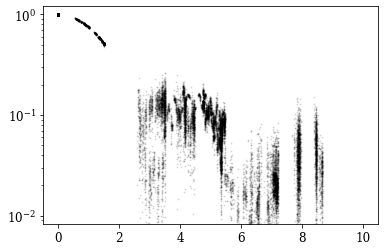

In [4]:
plt.scatter(uvd0/1e9, amp0, s=1, color='black', alpha=0.1, zorder=2)
plt.xlim(-0.5, 10.5)
plt.ylim(0.1/12, 0.1*12)
plt.yscale('log')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

plsed(ax, 'cache/Illinois_thermal_w5/Ma+0.5_i30/sed_Rh160.h5', label=[r'Model A ($a_*=0.5$ MAD, $R_\mathrm{high}=160$, $i=30$)'],  color='C0')
plsed(ax, 'cache/Illinois_thermal_w5/Sa+0.94_i30/sed_Rh40.h5', label=[r'Model B ($a_*=0.94$ SANE, $R_\mathrm{high}=40$, $i=30$)'], color='C1')
ax.set_xlim(1e9,  1e22)
ax.set_ylim(1e27, 1e37)
ax.set_xlabel(r'$\nu$ [Hz]')
ax.set_ylabel(r'$\nu L_\nu$ [erg/s]')
ax.errorbar(
    [86e9, 230e9, 1.4141e+14, 1.45e18], 
    [Fnu_to_nuLnu(86e9,1.9), Fnu_to_nuLnu(230e9,2.4), Fnu_to_nuLnu(1.4141e+14,1e-3), 1e33],
    yerr=[Fnu_to_nuLnu(86e9,0.2), 0, Fnu_to_nuLnu(1.4141e+14,1e-3)/2, 1e33/2],
    uplims=[False,False,True,True],
    fmt='o', color='k',
)
ax.legend()

fig.tight_layout()
fig.savefig('output/best_sed.pdf')

In [6]:
nmin = 2.5e9
nmax = 3.5e9

bmin = 6e9
bmax = 8e9

def plva(ax, name, label, color):

    mov = readimg(name)
    vis = mk.mockserve(mov, N=128)#512)

    U, V = vis.uvd
    uu = np.linspace( 0,   U/2, num=vis.shape[-1])
    vv = np.linspace(-V/2, V/2, num=vis.shape[-2], endpoint=False)
    t  = vis.meta.time.value

    amp = RegularGridInterpolator((t, vv, uu[::-1]), abs     (vis[...,::-1]))
  # phi = RegularGridInterpolator((t, v, u[::-1]), np.angle(vis[...,::-1]))
    uvd = np.linspace(0, 1.1e10, round(1e10/1e8)+1)
    
    n_all = []
    s_all = []
    l_all = []

    for t0 in tqdm(t[::10]):
        n_local = []
        s_local = []
        
        for i in range(-90,90,45):
            phi = np.pi * i / 180
            uu  = uvd * np.cos(phi)
            vv  = uvd * np.sin(phi)

            mask = (uu <= 0)
            p = np.array([np.repeat(t0, np.sum( mask)),  vv[ mask],  uu[ mask]]).T
            m = np.array([np.repeat(t0, np.sum(~mask)), -vv[~mask], -uu[~mask]]).T
    
            s = np.zeros(len(uvd))
            s[ mask] = amp(p)
            s[~mask] = amp(m)
        
            p = ax.semilogy(uvd/1e9, s/s[0], color=color, linewidth=1, alpha=1/10)

            l_all.append(np.median(s[(bmin <= uvd) & (uvd <= bmax)])/s[0])
            
            il = argrelextrema(s, np.less)[0]
            if len(il) > 0:
                i0 = il[0]
                if nmin <= uvd[i0] and uvd[i0] <= nmax:
                    n_local.append(uvd[i0])
                    s_local.append(s[i0]/s[0])

        if len(n_local) > 0:
            n_all += n_local
            s_all += s_local
            
    return n_all, s_all, l_all

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

ax.axvspan(nmin/1e9, nmax/1e9, color='k', alpha=1/10, edgecolor=None)
ax.axhspan(0, 0.04/0.5, color='k', alpha=1/10)

n0, s0, l0 = plva(ax, 'cache/Illinois_thermal_w5/Ma+0.5_i30/gt_Rh160_230GHz.h5', r'Model A ($a_*=0.5$ MAD, $R_\mathrm{high}=160$, $i=30$)',  'C0')
n1, s1, l1 = plva(ax, 'cache/Illinois_thermal_w5/Sa+0.94_i30/gt_Rh40_230GHz.h5', r'Model B ($a_*=0.94$ SANE, $R_\mathrm{high}=40$, $i=30$)', 'C1')

ax.scatter(np.median(n0)/1e9, np.median(s0), color='C0', edgecolor='k', zorder=2)
ax.plot([bmin/1e9, bmax/1e9], [np.median(l0), np.median(l0)], linewidth=4, color='k',  zorder=2)
ax.plot([bmin/1e9, bmax/1e9], [np.median(l0), np.median(l0)], linewidth=2, color='C0', zorder=2)

ax.scatter(np.median(n1)/1e9, np.median(s1), color='C1', edgecolor='k', zorder=2)
ax.plot([bmin/1e9, bmax/1e9], [np.median(l1), np.median(l1)], linewidth=4, color='k',  zorder=2)
ax.plot([bmin/1e9, bmax/1e9], [np.median(l1), np.median(l1)], linewidth=2, color='C1', zorder=2)

ax.set_xlim(-0.5, 10.5)
ax.set_ylim(0.1/12, 0.1*12)

ax.set_ylabel('230GHz normalized visibility amplitude $|V/V_0|$')
ax.set_xlabel('$u$-$v$ distance [G$\lambda$]')
    
fig.tight_layout()

fig.savefig('output/best_va.png', dpi=300)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 125.50it/s]


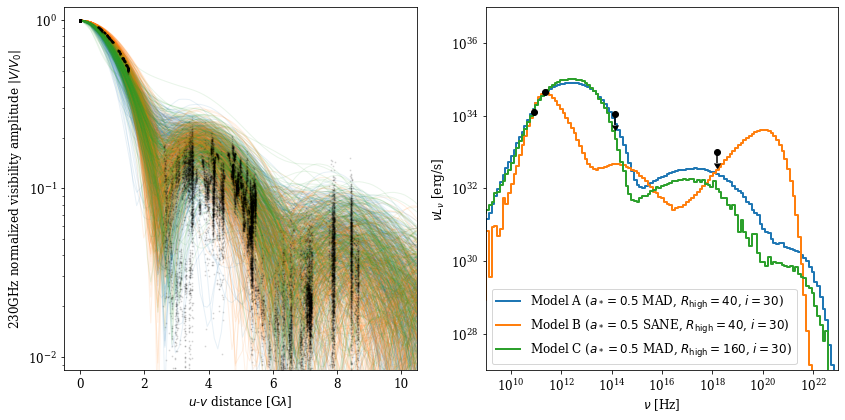

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))

n0, s0, l0 = plva(axes[0],
                  'cache/Illinois_thermal_w5/Ma+0.5_i30/gt_Rh40_230GHz.h5',
                  r'Model A ($a_*=0.5$ MAD, $R_\mathrm{high}=40$, $i=30$)',  'C0')
n1, s1, l1 = plva(axes[0],
                  'cache/Illinois_thermal_w5/Sa+0.5_i30/gt_Rh40_230GHz.h5',
                  r'Model B ($a_*=0.5$ SANE, $R_\mathrm{high}=40$, $i=30$)', 'C1')
n2, s2, l2 = plva(axes[0],
                  'cache/Hamr_varkappa/mad_a0.5_i30/gt_Rh160_230GHz.h5',
                  r'Model B ($a_*=0.5$ MAD, $R_\mathrm{high}=160$, $i=30$)', 'C2')

axes[0].scatter(uvd0/1e9, amp0, s=1, color='black', alpha=0.1, zorder=2)
axes[0].set_xlim(-0.5, 10.5)
axes[0].set_ylim(0.1/12, 0.1*12)
axes[0].set_ylabel('230GHz normalized visibility amplitude $|V/V_0|$', fontsize=12)
axes[0].set_xlabel('$u$-$v$ distance [G$\lambda$]',                    fontsize=12)

plsed(axes[1], 'cache/Illinois_thermal_w5/Ma+0.5_i30/sed_Rh40.h5', label=[r'Model A ($a_*=0.5$ MAD, $R_\mathrm{high}=40$, $i=30$)'],  color='C0')
plsed(axes[1], 'cache/Illinois_thermal_w5/Sa+0.5_i30/sed_Rh10.h5', label=[r'Model B ($a_*=0.5$ SANE, $R_\mathrm{high}=40$, $i=30$)'], color='C1')
plsed(axes[1], 'cache/Hamr_varkappa/mad_a0.5_i30/sed_Rh160.h5',    label=[r'Model C ($a_*=0.5$ MAD, $R_\mathrm{high}=160$, $i=30$)'], color='C2')
axes[1].set_xlim(1e9,  1e23)
axes[1].set_ylim(1e27, 1e37)
axes[1].set_xlabel(r'$\nu$ [Hz]',          fontsize=12)
axes[1].set_ylabel(r'$\nu L_\nu$ [erg/s]', fontsize=12)
axes[1].errorbar(
    [86e9, 230e9, 1.4141e+14, 1.45e18], 
    [Fnu_to_nuLnu(86e9,1.9), Fnu_to_nuLnu(230e9,2.4), Fnu_to_nuLnu(1.4141e+14,1e-3), 1e33],
    yerr=[Fnu_to_nuLnu(86e9,0.2), 0, Fnu_to_nuLnu(1.4141e+14,1e-3)/2, 1e33/2],
    uplims=[False,False,True,True],
    fmt='o', color='k',
)
axes[1].legend(fontsize=12)
    
fig.tight_layout()

fig.savefig('output/bestbets.png', dpi=300)